# MNIST on PE Network

In [178]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader
importlib.reload(mnist_loader)
importlib.reload(NN)
importlib.reload(Layer);

In [378]:
train, validate, test = mnist_loader.load_data_wrapper()
train = [torch.tensor(train[0][:]).float().to(device), torch.tensor(train[1][:]).float().to(device)]

In [379]:
def MakeBatches(data_in, data_out, batch_size=10):
    '''
    batches = MakeBatches(data_in, data_out, batch_size=10)
    
    Breaks up the dataset into batches of size batch_size.
    
    Inputs:
      data_in    is a list of inputs
      data_out   is a list of outputs
      batch_size is the number of samples in each batch
      
    Output:
      batches is a list containing batches, where each batch is:
                 [in_batch, out_batch]
    '''
    N = len(data_in)
    batches = []
    for k in range(0, N, batch_size):
        din = data_in[k:k+batch_size]
        dout = data_out[k:k+batch_size]
        if isinstance(din, (list, tuple)):
            batches.append( [torch.stack(din, dim=0).float().to(device) , torch.stack(dout, dim=0).float().to(device)] )
        else:
            batches.append( [din.float().to(device) , dout.float().to(device)] )
    return batches

In [380]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=784))
net.AddLayer(Layer.PELayer(n=600))
net.AddLayer(Layer.PELayer(n=600))
net.AddLayer(Layer.TopPELayer(n=10))

## Train

In [390]:
net.learning_tau = 400.
epochs = 30
T = 2.
start_time = time.time()
batch_size = 100
fp = FloatProgress(min=0,max=epochs*len(train[0]))  
display(fp)
for k in range(epochs):
    batches = MakeBatches(train[0], train[1], batch_size=batch_size)
    for x in batches:
        net.Reset()
        net.Infer(T, x[0], x[1])
        fp.value += batch_size
end_time = time.time()
print('Total time: '+str(end_time-start_time))

Total time: 5106.935925722122


tensor([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


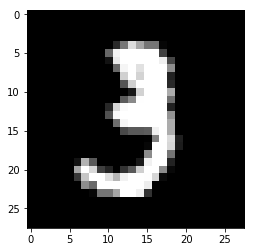

In [198]:
print(batches[0][1][10])
plt.imshow(np.reshape(batches[0][0][10],[28,28]), cmap='gray')

In [203]:
net.Save('mnist_net.npy')

In [204]:
net = NN.NeuralNetwork()
net.Load('mnist_net.npy')

tensor([ 0.0689,  0.0002,  0.1555,  0.1750,  0.0004,  0.2353,  0.0881,
         0.0003,  0.1765,  0.0998], device='cuda:0')

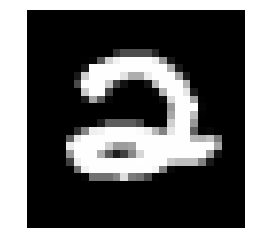

In [394]:
p = 390
plt.imshow(np.reshape(test[0][p],[28,28]), cmap='gray'); plt.axis('off');
net.Reset()
net.Predict(3., test[0][p])

tensor([ 6.0330e-11,  3.7360e-11,  3.6544e-02,  1.3489e-07,  2.8917e-11,
         1.0242e-10,  1.8635e-10,  3.0650e-11,  4.8862e-11,  9.6346e-01], device='cuda:0')

In [353]:
net.Reset()
net.learning_tau = 20.
net.Infer(.2, test[0][p], test[1][p])

In [322]:
net.Reset()
gen = net.Generate(10., test[1][3])

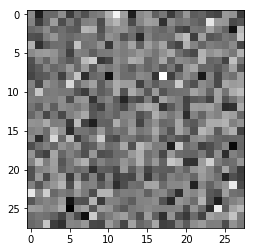

In [323]:
plt.imshow(np.reshape(gen,[28,28]), cmap='gray')

In [209]:
gen

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -0.9994, -0.9978, -0.9970, -0.9985, -0.9993, -0.9995, -0.9999,
        -1.0000, -0.9973, -0.9970, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -0.9864, -0.9989, -0.9999,
        -0.9995, -0.9969, -1.0269, -1.1425, -1.1733, -1.0047, -0.9988,
        -0.9988, -0.9934, -0.9153, -0.8584, -0.8565, -0.9337, -0.9919,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -0.9989, -0.9993, -0.9993,
        -0.9994, -0.9963, -1.0959, -1.2525, -1.2468, -1.0113, -0.8611,
      